<h1>Домашняя работа по классификации персонажей из Симпсонов</h1>

В рамках данной работы будет использована базовая архитектура, предложенная в оригинальном ноутбуке с дополнениями в виде двух полносвязных слоёв, batchnorm преобразованиий между свёрточными слоями и дропаута между полносвязными.

Кроме этого, изображения будут аугментированы (кроп, поворот, горизонтальное отражение) и размножены в соответствии с их количеством в оригинальном датасете с целью балансировки.

 Импортируем основные модули и библиотеки, проверим наличие cuda.

In [1]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [2]:
import pickle
import numpy as np
import pandas as pd
import random
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
import seaborn as sns
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True

In [3]:
!cp -r "../input/journey-springfield" "./"

In [4]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu ")

Определим класс SimpsonsDataset наследующий от Dataset.

In [5]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [6]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [7]:
TRAIN_DIR = Path('./journey-springfield/train/simpsons_dataset')
TEST_DIR = Path('../input/journey-springfield/testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [9]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, stratify=train_val_labels, random_state=111)

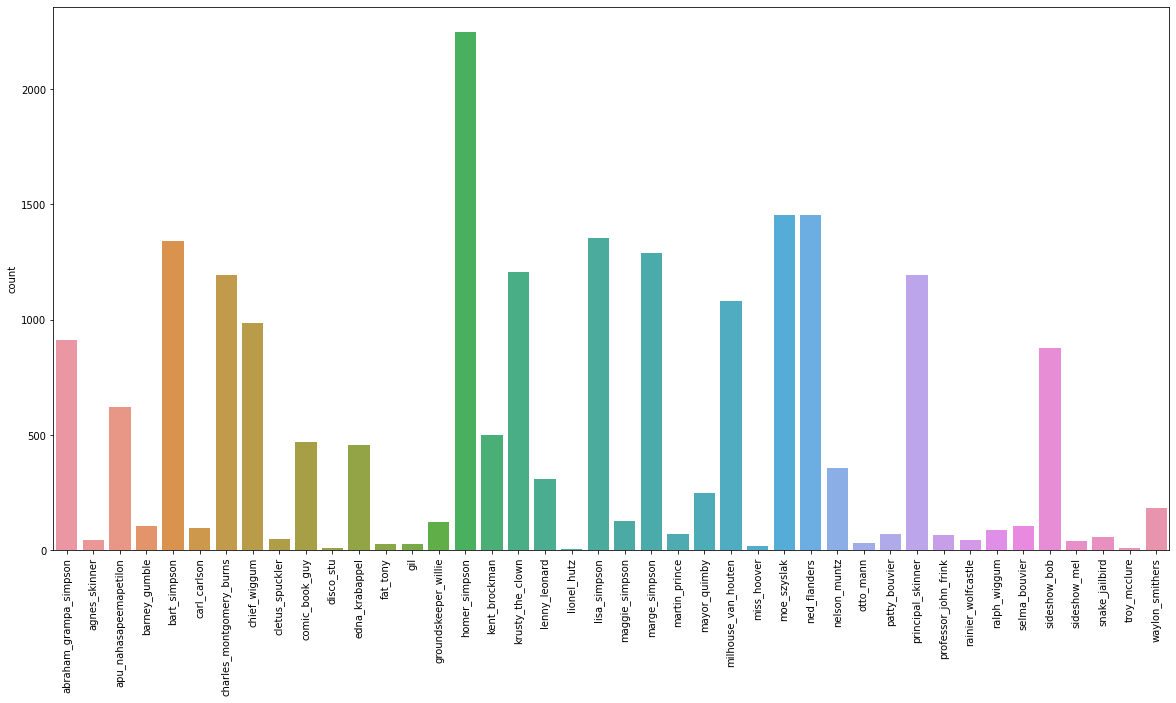

In [10]:
from collections import Counter
data_dict = dict(Counter([x.parent.name for x in train_val_files]))
data = pd.DataFrame(data = data_dict.values(), index=data_dict.keys(), columns=['count'])
plt.figure(figsize=(20,10))
sns.barplot(x = data.index, y = data['count']).set_xticklabels(data.index, rotation=90)
plt.show()

Масками соберем необходимое количество информации, которое нужно добавить

In [19]:
mask = data['count'] < 15000
data.loc[mask, 'To_add'] = (2100 - data['count']).astype(int)
data.loc[~mask, 'To_add'] = 0
data['from_one_image'] = (np.ceil(data['To_add'] / data['count'])).astype(int)
data.head()

,count,To_add,from_one_image
abraham_grampa_simpson,913,1187,2
agnes_skinner,42,2058,49
apu_nahasapeemapetilon,623,1477,3
barney_gumble,106,1994,19
bart_simpson,1342,758,1


Стандартные аугментации

In [13]:
augmenters = {
    'Crop': transforms.Compose([
                                transforms.Resize(size=300, max_size=301),
                                transforms.CenterCrop(size=300),
                                transforms.RandomCrop(250)
                                ]),
    'Rotate': transforms.RandomRotation(degrees=(-25, 25)),
    'HFlip': transforms.RandomHorizontalFlip(p=1)
}

Так выглядят:

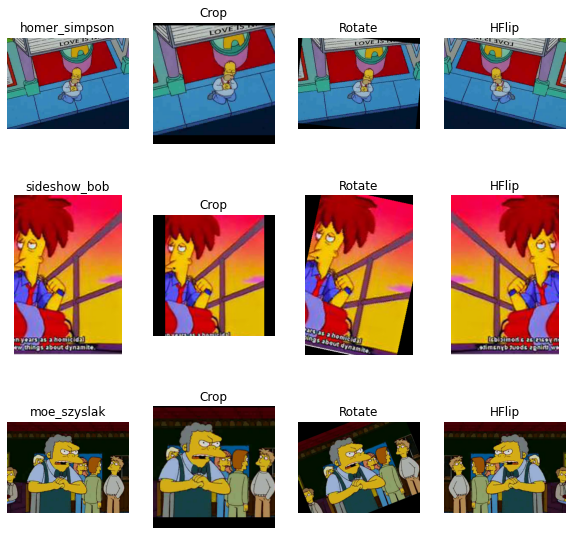

In [14]:
n_examples = 3
train_dataset = SimpsonsDataset(train_val_files, mode='train')

fig, ax = plt.subplots(nrows=n_examples, ncols=(len(augmenters) + 1),figsize=(10, 10))

for i in range(n_examples):
    random_character = int(np.random.uniform(0, len(train_val_files)))
    img_orig = train_dataset.load_sample(train_val_files[random_character])
    img_label = train_val_files[random_character].parent.name
    
    ax[i][0].imshow(img_orig)
    ax[i][0].set_title(img_label)
    ax[i][0].axis('off')
        
    for j, (augmenter_name, augmenter) in enumerate(augmenters.items()):
        img_aug = augmenter(img_orig)
        ax[i][j + 1].imshow(img_aug)
        ax[i][j + 1].set_title(augmenter_name)
        ax[i][j + 1].axis('off')

In [20]:
data.loc[character]

count              310
To_add            1790
from_one_image       6
Name: lenny_leonard, dtype: int64

Преобразуем все картинки 

In [21]:
for image_path in tqdm(train_files):
    path = image_path.parents[0]
    character = image_path.parent.name
    img = train_dataset.load_sample(image_path)
    # if we don't need to add any images, we can continue without transformation
    if data.loc[character]['To_add'] <= 0:
        continue
  
    if data.loc[character]['from_one_image'] > data.loc[character]['To_add']:
        iter_size = data.loc[character]['To_add']
    else:
        iter_size = data.loc[character]['from_one_image']
    data.loc[character]['To_add'] -= iter_size
    
    for i in range(int(iter_size)):
        augmenter = random.choice(list(augmenters.values()))
        aug_img = augmenter(img)
        aug_img.save(f"{path}/{image_path.name.split('.')[0]}_{i}.jpg")

100%|██████████| 15699/15699 [05:03<00:00, 51.71it/s] 


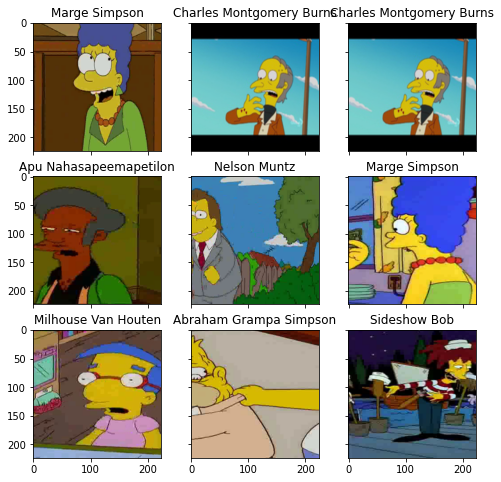

In [22]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, len(train_dataset)))
    im_train, label = train_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                train_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_train.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Модель, похожа на ту из прошлой дз


In [45]:
class MyCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.05),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.linear = nn.Sequential(
            nn.Flatten(),
            nn.Linear(96 * 5 * 5, 96 * 5 * 5),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(96 * 5 * 5, 96 * 5 * 5),
            nn.ReLU(),
        )
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        
        x = self.linear(x)

#         x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [24]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [25]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

Вторая сеть

In [43]:

class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
           nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
           nn.BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), #добавлено для оптимизации
           nn.LeakyReLU(), #nn.LeakyReLU(), #nn.ReLU(),
           nn.MaxPool2d(kernel_size=2)
        )


        self.conv2 = nn.Sequential(
           nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
           nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), #добавлено для оптимизации
           nn.LeakyReLU(), #nn.LeakyReLU(), #nn.ReLU(),
           nn.MaxPool2d(kernel_size=2)
        )
        
        
        self.conv3 = nn.Sequential(
           nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
           nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), #добавлено для оптимизации
           nn.LeakyReLU(), #nn.LeakyReLU(), #nn.ReLU(),
           nn.MaxPool2d(kernel_size=2)
        )


        
        self.conv4 = nn.Sequential(
           nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
           nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), #добавлено для оптимизации
           nn.LeakyReLU(), #nn.LeakyReLU(), #nn.ReLU(),
           nn.MaxPool2d(kernel_size=2)
        )
        

        
        self.conv5 = nn.Sequential(
           nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
           nn.BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), #добавлено для оптимизации
           nn.LeakyReLU(), #nn.LeakyReLU(), #nn.ReLU(),
           nn.MaxPool2d(kernel_size=2)
        )
                
        self.out = nn.Linear(96 * 5 * 5, n_classes)
        self.ln1 = nn.Linear(96 * 5 * 5, 1024)
        self.bn6 = nn.BatchNorm1d(1024)
        self.relu6 = nn.LeakyReLU()
        self.ln2 = nn.Linear(1024, 256)
        self.bn7 = nn.BatchNorm1d(256)
        self.relu7 = nn.LeakyReLU()

  
  
    def forward(self, x):
   
        x = self.conv1(x)
        
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        #print(x.size())
        #x=x+sk1
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        #print(x.size())
        #x=x+sk2
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)

   
        x = self.conv4(x)
       
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.pool4(x)
        x = self.conv5(x)
        #print(x.size())
        #x=x+sk4
        x = self.bn5(x)
        x = self.relu5(x)
        x = self.pool5(x)

        x = x.view(x.size(0), -1)

        x=self.ln1(x)
        x=self.bn6(x)
        x=self.relu6(x)
        x=self.ln2(x)
        x=self.bn7(x)
        x=self.relu7(x)
        logits = self.out(x)
        return logits
SimpleCnn=SimpleCnn(n_classes)

Функции для тренировки и предсказания те же самые, что и в оригинальном ноутбуке.

In [36]:
def train(train_dataset, val_dataset, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"
    opt = torch.optim.AdamW(model.parameters())
    criterion = nn.CrossEntropyLoss()
    
    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [37]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [46]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = MyCnn(n_classes).to(DEVICE)
print(f"We will classify {n_classes} classes")
print(simple_cnn)


We will classify 42 classes
MyCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.05, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(6

In [39]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
train_val_labels = [path.parent.name for path in train_val_files]
train_files, _ = train_test_split(train_val_files, test_size=0.25, stratify=train_val_labels, random_state=111)

val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [ ]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=20, batch_size=128)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best') 
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
print(label_encoder.classes_)

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Рассчитаем получившуюся f1-метрику.

In [ ]:
from sklearn.metrics import f1_score
print(actual_labels)
print(y_pred)
f1_score(actual_labels, y_pred,average='micro')

Формируем сабмит.

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
import pandas as pd
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

In [ ]:
my_submit.to_csv('augmented2linear.csv', index=False)


https://www.kaggle.com/apropsys

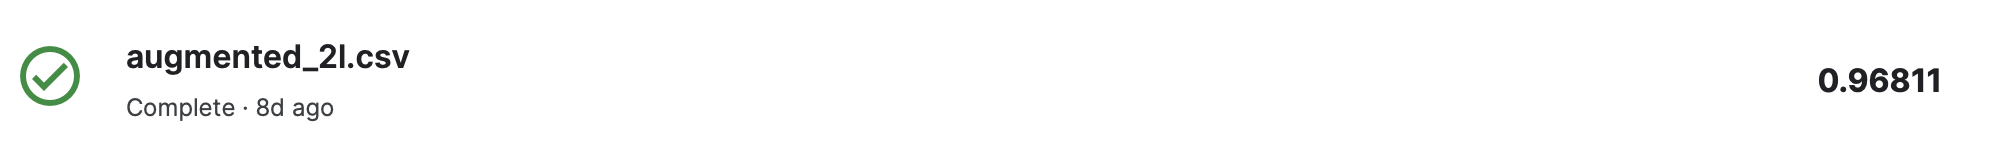